# Advanced Lane Finding Project

This project goes through the following steps:
1. Compute camera matrix and distortion coefficients to correct a distorted chessboard image.
2. Apply a distortion correction to a test image (saved in output folder).
3. Create a thresholded binary image using color transforms, gradients, and other methods.
4. Apply a perspective transform to rectify each image to a "birds-eye view".
5. Identify lane line pixels in the corrected binary image and fit with a curved functional form.
6. Calculate the radius of curvature of the lane and the position of the vehicle with respect to center.
7. Provide an example image of the result plotted back down onto the road.
8. Create a final video where the lanes are identified in each frame and provide a link to the output.

### STEP 0: Import and read in a calibration image

Y:720 X:1280


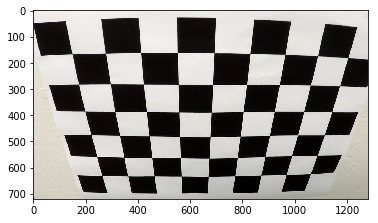

In [18]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

#Read in a calibration chessboard image and print image size
img = mpimg.imread('./camera_cal/calibration2.jpg')
shape = "Y:" + str(img.shape[0]) + " X:" + str(img.shape[1])
plt.imshow(img)
print(shape)

### STEP 1: Compute camera matrix and distortion coefficients to correct a distorted chessboard image.

In [19]:
#Calibration function that outputs camera matrix and distortion coefficients from gathered image and object points.

def calibrate_camera(nx=9, ny=6):
    
    #Read in and make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    #Storing object points and image points from all images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in mimage plane
    
    #Preparing object points
    objp = np.zeros((ny*nx,3), np.float32) 
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #Generate x, y coordinates 
    
    for fname in images:
        #Reading in each image
        img = mpimg.imread(fname) 
        
        #Convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        #Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
        #If corners are found, add object points and image points to intialised array
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            #Draw/display corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #plt.imshow(img)
    
    ret, matrix, dist_coef, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, matrix, dist_coef, rvecs, tvecs

### STEP 2: Running camera calibration and distortion correction on a calibration image.

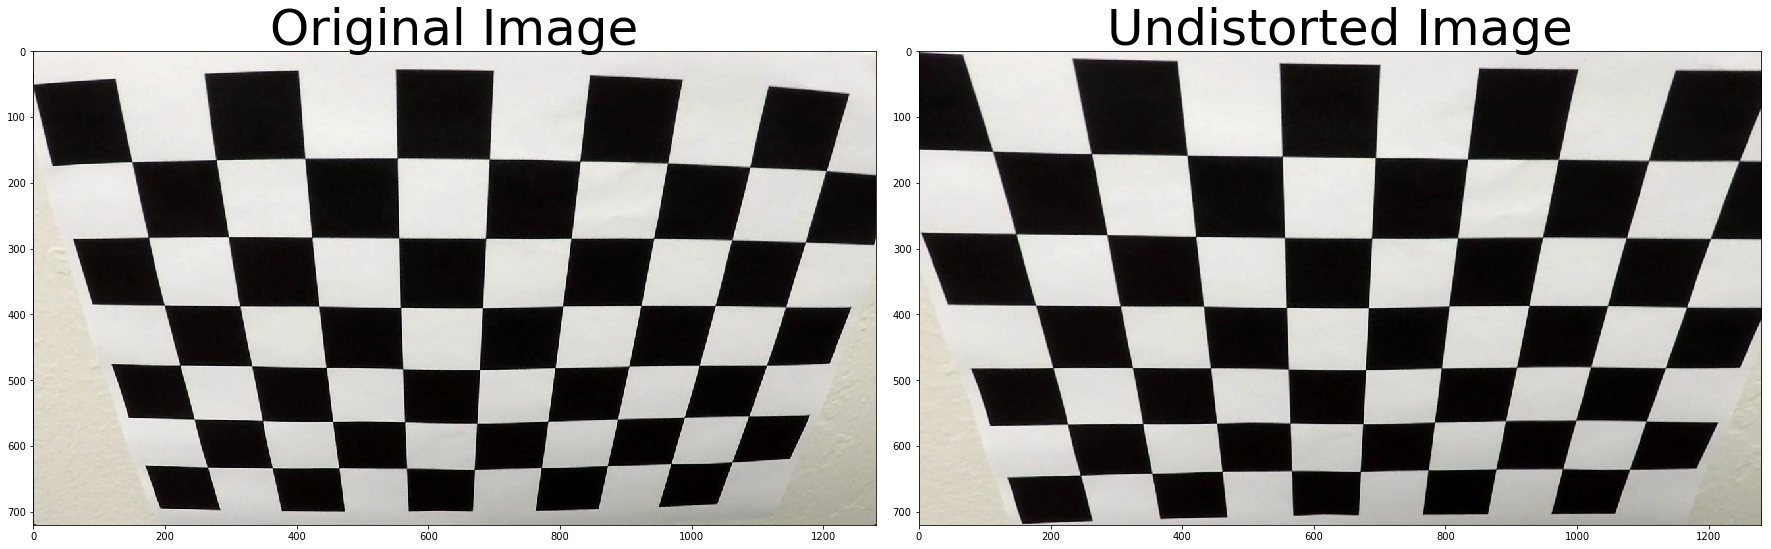

In [20]:
#Run calibrate camera function to get matrix and dist_coef variables
matrix = calibrate_camera()[1]
dist_coef = calibrate_camera()[2]

#Reading in calibration example image
img = mpimg.imread('camera_cal/calibration2.jpg')

#Undistoring the image using OpenCV function 
undistorted = cv2.undistort(img, matrix, dist_coef, None, matrix)

#Plotting original and undistorted image side-by-side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### STEP 3: Create a threshold binary image using color transforms, gradients, and other methods. Several threshold functions will be defined and then combined to create a binary image containing lane pixels.

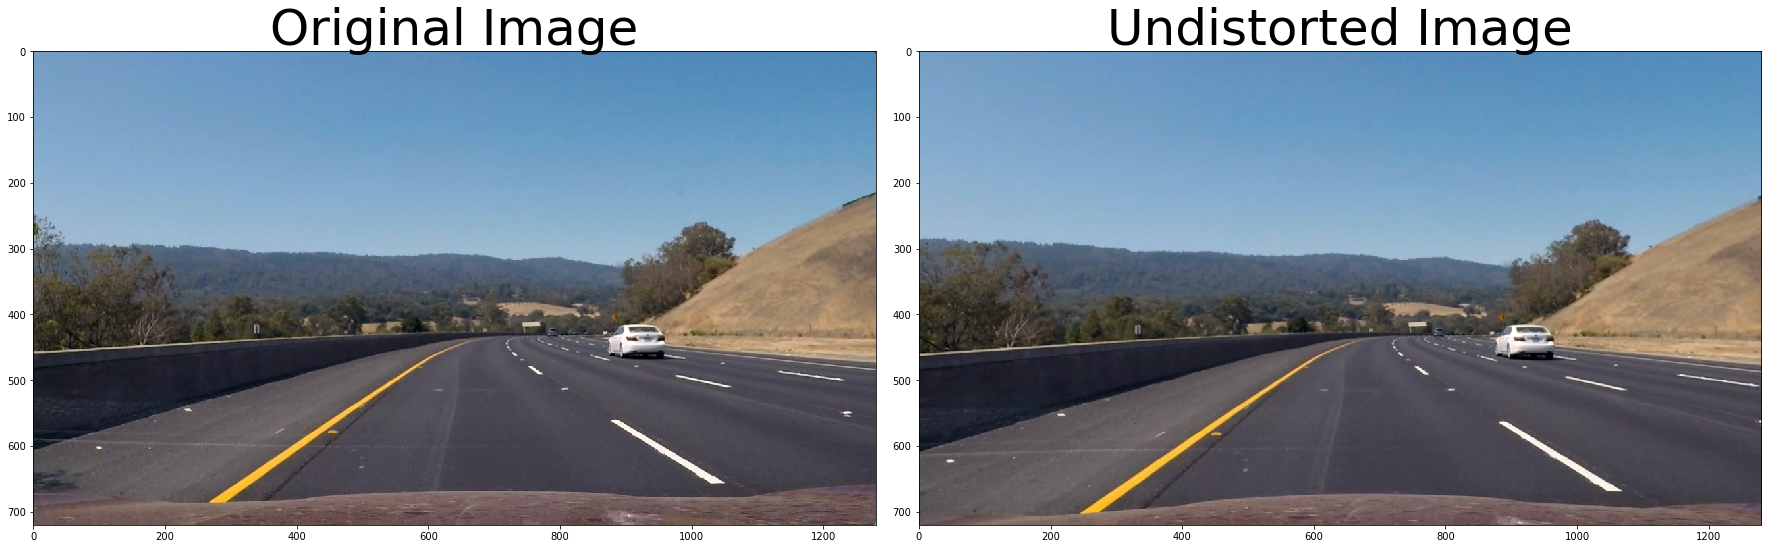

In [21]:
#First step is to load in one of the test images and undistort it.
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted_img = cv2.undistort(img, matrix, dist_coef, None, matrix)

#Plotting original and undistorted image side-by-side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [22]:
#Applying sobel function that takes in 'x' or 'y' for the orientation. 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y' :
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

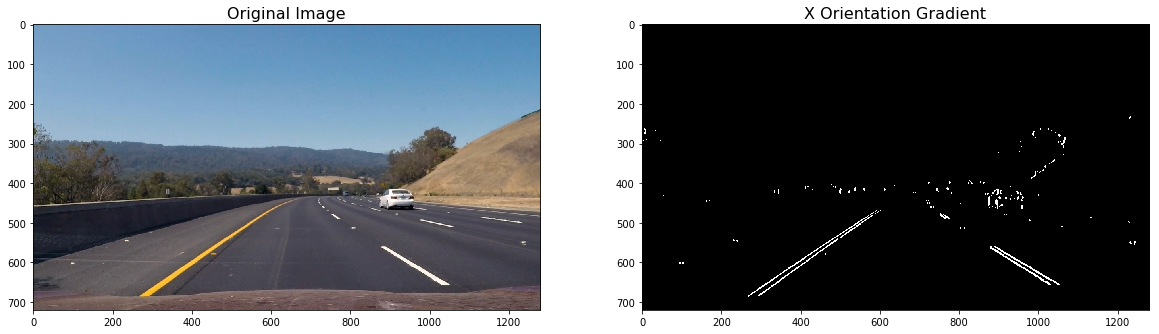

In [23]:
#Run function in both orientations and compare with original image
#X orientation
grad_x = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(70, 200))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(img)
ax2.set_title('X Orientation Gradient', fontsize=16)
ax2.imshow(grad_x, cmap='gray')

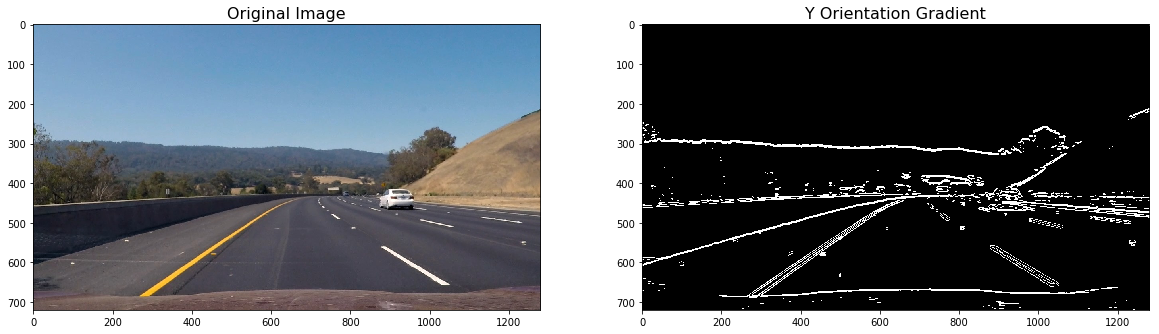

In [24]:
#Run same function with 'y' orient.
#Y orientation
grad_y = abs_sobel_thresh(img, orient='y', sobel_kernel=15, thresh=(30, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(img)
ax2.set_title('Y Orientation Gradient', fontsize=16)
ax2.imshow(grad_y, cmap='gray')

In [25]:
#In the next step, the magnitude of the gradient is computed and a threshold is applied.
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(np.power(abs_sobel_x, 2) + np.power(abs_sobel_y, 2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobelxy)
    mag_binary[(scaled_sobelxy >= mag_thresh[0]) & (scaled_sobelxy <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary

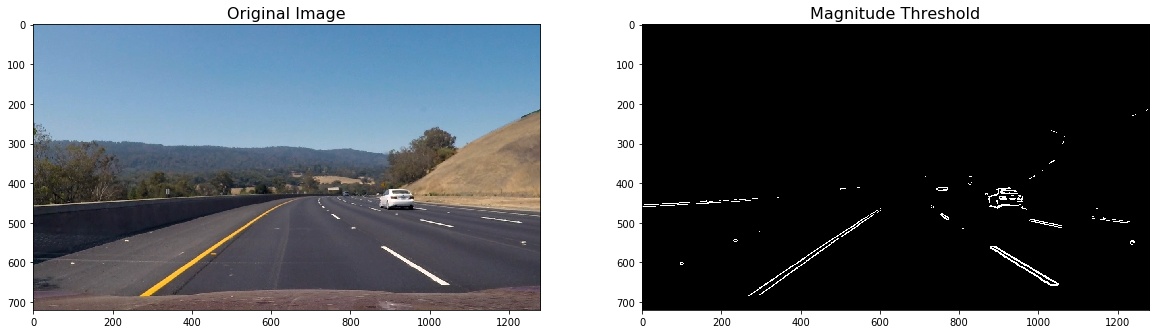

In [26]:
#Run mag_thresh function
mag_img = mag_thresh(img, sobel_kernel=15, mag_thresh=(100, 220))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(img)
ax2.set_title('Magnitude Threshold', fontsize=16)
ax2.imshow(mag_img, cmap='gray')

In [27]:
#Next, a direction threshold function is defined. For this function, we can isolate edges we want by orientation.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobel_x)
    abs_sobely = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradient_theta = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(gradient_theta)
    dir_binary[(gradient_theta >= thresh[0]) & (gradient_theta <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary

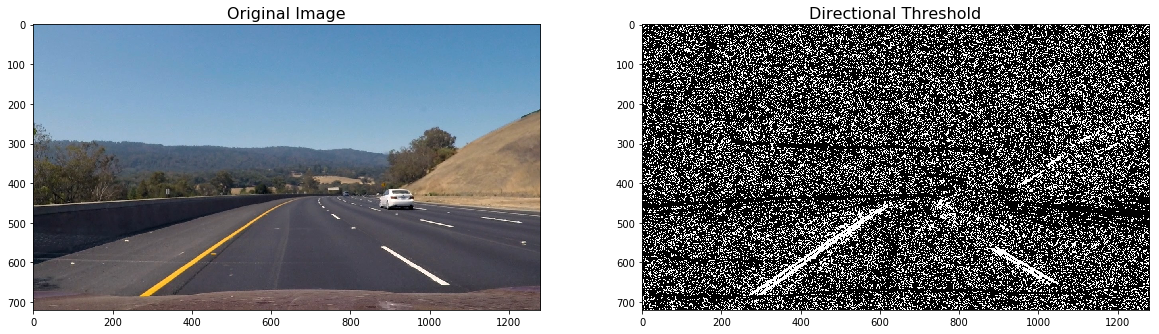

In [28]:
#Run dir_threshold function
dir_img = dir_threshold(img, sobel_kernel=9, thresh=(0.8, 1.2))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(img)
ax2.set_title('Directional Threshold', fontsize=16)
ax2.imshow(dir_img, cmap='gray')

In [29]:
#Calculating a color threshold using HLS space.
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel. S channel works best for picking up lane lines.
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

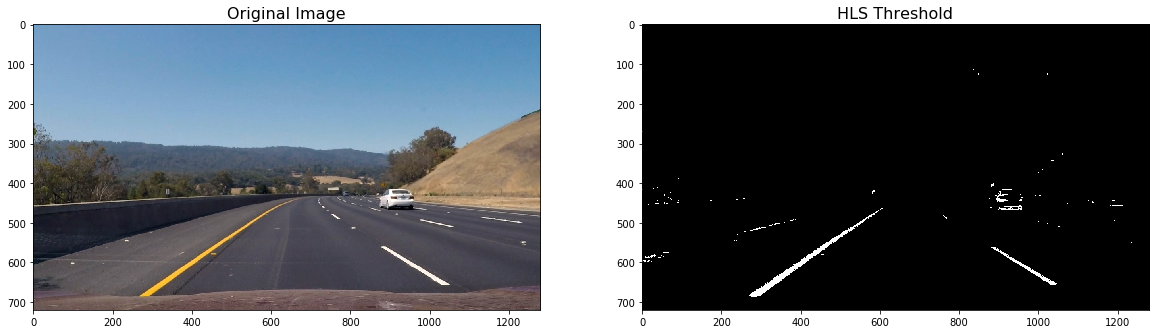

In [30]:
#Run hls_select function
img_hls = hls_select(img, thresh=(120,255))

#Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(img)
ax2.set_title('HLS Threshold', fontsize=16)
ax2.imshow(img_hls, cmap='gray')

For the last step, a pipeline is created to combine different thresholds to identify the lane line pixels.

In [31]:
def pipeline(grad_x, dir_threshold, img_hls):
    #Combine previous thresholds
    combined = np.zeros_like(grad_x)
    combined[(grad_x == 1) | (dir_threshold == 1) | (img_hls == 1)] = 1
    return combined

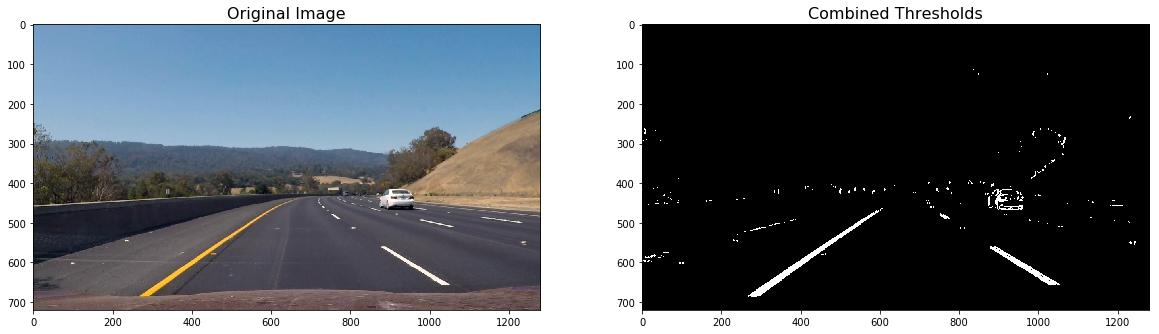

In [32]:
#Run pipeline
combined = pipeline(grad_x, dir_threshold, img_hls)

#Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(img)
ax2.set_title('Combined Thresholds', fontsize=16)
ax2.imshow(combined, cmap='gray')

### STEP 4: Apply a perspective transform to get a "birds-eye" view of each image.

In [33]:
#Four points selected to define cropped area to perform the transform on.
bottom_left = [280, 700]
top_left = [600, 460]
top_right = [725, 460]
bottom_right = [1125, 700]

#Four points selected for desired transform plane
bottom_left_dst = [250, 720]
top_left_dst = [250, 0]
top_right_dst = [1065, 0]
bottom_right_dst = [1065, 720]

#Define perspective warp transform function
def warp(img, source=None, dst=None):
    img_size = (img.shape[1], img.shape[0])
    #Source points
    if source is None:
        source = np.float32([bottom_left, bottom_right, top_right, top_left])
    #Destination points
    if dst is None:
        dst = np.float32([bottom_left_dst, bottom_right_dst, top_right_dst, top_left_dst]) #Destination points
    #Computing perspective transform
    M = cv2.getPerspectiveTransform(source, dst)
    #Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, source)
    #Create warp transform
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

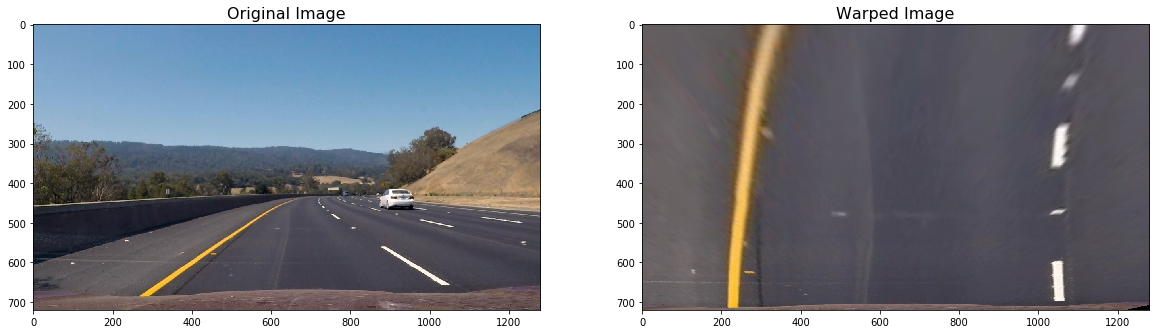

In [34]:
source = np.float32(
    [[280,  700],  # Bottom left
     [600,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst = np.float32(
    [[250,  720],  # Bottom left
     [250,  0],  # Top left
     [1065,  0],  # Top right
     [1065, 720]]) # Bottom right

warped_im, _ , Minv  = warp(img, source, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(img)
ax2.set_title('Warped Image', fontsize=16)
ax2.imshow(warped_im)

### STEP 5: Identify lane line pixels in the corrected binary image and fit with a curved functional form.

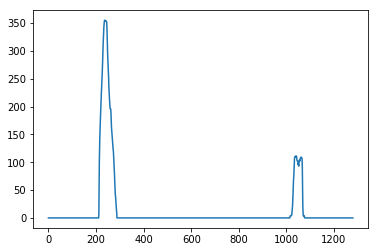

In [35]:
#First step is to determine which pixels are part of the lane lines. By plotting the binary activations with 
#a histogram, the lane lines can be identified.

#Run warped function on binary combined image.
warped_combined = warp(combined)[0]

#Define a function to plot a histogram that takes an image parameter.
def hist(img):
    bottom_half = img[img.shape[0]//2:, :]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

#Create and visualize histogram of the binary activations
histogram = hist(warped_combined)
plt.plot(histogram)
#plt.imshow(warped_combined)

#### Part 1: Implementing Sliding Windows and Fit a Polynomial

In [36]:
#Starting function to track left and right lane lines.
def find_lane_pixels(img):
    histogram = hist(img)
    #Output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    #Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #Establish hyperparamters
    #Number of sliding windows
    nwindows = 9
    #Set the width of the windows +/- margin
    margin = 100
    #Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Setting height of windows
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    #Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #Step through each window
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        #Draw windows on visualization image
        cv2.rectangle(out_img,(win_xleft_low, win_y_low),
        (win_xleft_high, win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
        (win_xright_high, win_y_high), (0,255,0), 2)
        #Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        #If indices of pixels found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    #Concatenate arrays of indices
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    
    #Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
    

In [37]:
#Polynomial function to fit line to the pixels found in sliding windows
def fit_polynomial(img):
    #Find the lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)
    #Fit second order polynomial to each of the lane lines
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    #Visualization
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    return out_img

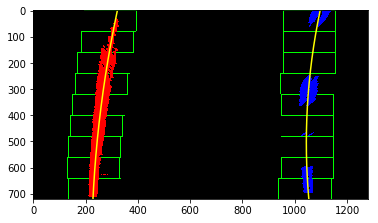

In [38]:
#Run the function and display curves
out_img = fit_polynomial(warped_combined)
plt.imshow(out_img)

#### Part 2: Searching for lane lines from prior 

In [39]:
# Polynomial fit values from the previous frame
left_fit = np.array([1.13914219e-04, -2.11293052e-01,  3.21640012e+02])
right_fit = np.array([2.05568834e-04, -2.07889523e-01,  1.09679457e+03])

def fit_polynomial_prior(img_shape, leftx, lefty, rightx, righty):
    #Fit a second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [40]:
def search_around_poly(img):
    #Establishing hyperparamters
    margin = 100
    #Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Setting boundaries based on activated x-values within margin
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    #extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #Fit new polynomials
    left_fitx, right_fitx, ploty = fit_polynomial_prior(img.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return result, (left_fitx, ploty), (right_fitx, ploty)

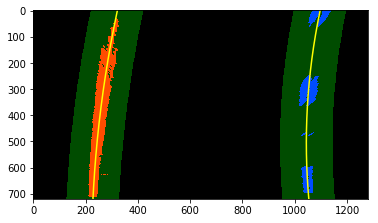

In [41]:
result = search_around_poly(warped_combined)[0]
plt.imshow(result)

### STEP 6: Calculate the radius of curvature of the lane and the position of the vehicle with respect to center.

In [16]:
#Defined function calculates curvature of polynomial functions in meters
def measure_curvature_real(leftx, rightx, img_shape):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx = leftx[::-1]  #Reverse to match top-to-bottom in y
    rightx = rightx[::-1] #Same as above
    
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Define y-value where we want radius of curvature and fit new polynomials
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #Implement the calculation of R_curve(radius of curvature)
    left_curverad = ((1 + ((2 * left_fit_cr[0] * y_eval * ym_per_pix) + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + ((2 * right_fit_cr[0] * y_eval * ym_per_pix) + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
    
    return left_curverad, right_curverad

Define 'leftx' and 'rightx' variables from search_around_poly() function and run measure_curvature_real() function.

Left line curvature: 1443.22407283 m
Right line curvature: 799.722808823 m


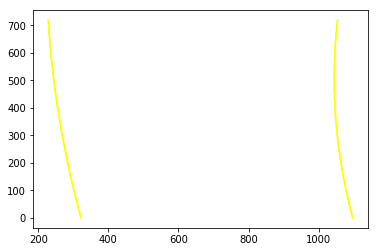

In [44]:
left_points = search_around_poly(warped_combined)[1]
right_points = search_around_poly(warped_combined)[2]
curvature_rads = measure_curvature_real(leftx = left_points[0], rightx = right_points[0], img_shape = img.shape)
print('Left line curvature:', curvature_rads[0], 'm')
print('Right line curvature:', curvature_rads[1], 'm')

#### Part 2: Defining and running function to find position of vehicle with respect to center.

In [27]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/700):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
    #Car position
    car_pos = (leftx[-1] + rightx[-1])/2
    # Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [28]:
#Run the function
offsetx = car_offset(leftx = left_points[0], rightx = right_points[0], img_shape=img.shape)

print ('Car offset from center:', offsetx, 'm.')

Car offset from center: -0.00582111640791 m.


### STEP 7: Provide an example image of the result plotted back down onto the road.

In [29]:
def draw_result(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

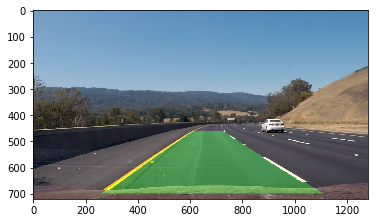

In [30]:
img_lane = draw_result(img, warped_combined, left_points, right_points, Minv)
plt.imshow(img_lane)

#### Part 2: Adding lane radius and vehicle position metrics to image.

In [31]:
def add_metrics(img, leftx, rightx):
    #Calculate radius curvature
    curve_radius = measure_curvature_real(leftx=leftx, rightx=rightx, img_shape = img.shape)
    
    #Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)
    
    #Display lane curvature and car offset
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curve_radius[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curve_radius[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

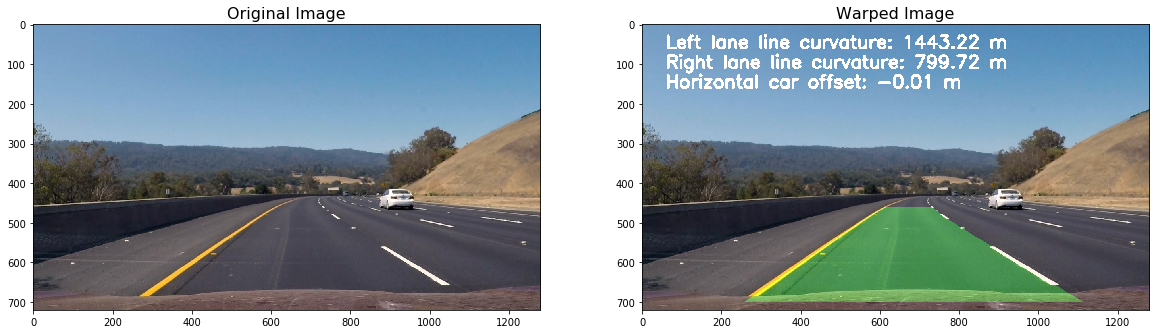

In [32]:
#Run function
out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])

#Plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(img)
ax2.set_title('Warped Image', fontsize=16)
ax2.imshow(out_img)

### STEP 8: Create a final video where the lanes are identified in each frame and provide a link to the output.

In [33]:
class ProcessImage:  
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)
        
        # Calibrate camera
        for i in range(len(images)):
            self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(nx=9, ny=6)

    def __call__(self, img):
        # Undistort image
        img = cv2.undistort(img, matrix, dist_coef, None, matrix)

        # Calculate directional gradient
        grad_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(70, 200))

        # Calculate gradient direction
        dir_binary = dir_threshold(img, sobel_kernel=9, thresh=(0.8, 1.2))

        # Calculate color threshold
        col_binary = hls_select(img, thresh=(120, 255))

        # Combine all the thresholds to identify the lane lines
        combined = pipeline(grad_binary, dir_threshold, col_binary)

        # Apply a perspective transform to rectify binary image ("birds-eye view")
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
            [600,  460],  # Top left
            [725,  460],  # Top right
            [1125, 700]]) # Bottom right

        dst_coordinates = np.float32(
             [[250,  720],  # Bottom left
             [250,  0],  # Top left
             [1065,  0],  # Top right
             [1065, 720]]) # Bottom right
        
        combined_warped, _, Minv = warp(combined, src_coordinates, dst_coordinates)
        
        image_value = len(glob.glob('camera_cal/calibration*.jpg'))
        for image in range(image_value):
            if image == 0:
                left_points = (find_lane_pixels(combined_warped)[0], find_lane_pixels(combined_warped)[1])
                right_points = (find_lane_pixels(combined_warped)[2], find_lane_pixels(combined_warped)[3])
                out_img = find_lane_pixels(combined_warped)[4]
            else:
                out_img, left_points, right_points = search_around_poly(combined_warped)
        
        # Warp the detected lane boundaries back onto the original image.
        img_lane = draw_result(img, combined_warped, left_points, right_points, Minv)
            
        # Add metrics to the output img
        out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
            
        return out_img

[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


100%|█████████▉| 1260/1261 [59:16<00:04,  4.97s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 55min 56s, sys: 52.4 s, total: 56min 49s
Wall time: 59min 19s


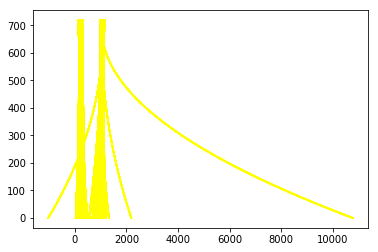

In [35]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

In [36]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))